# Machine-Learning tutorial for classification

## Objective
1. Predict diagnostic label from functional connectome
2. Predict MRI acquisition site from functional connectome

## Dataset
[ABIDE (Autism)](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_abide_pcp.html)

## Preprocessing 
### (Note: this is done in [ABIDE_fmri_data_prepare.ipynb](./ABIDE_fmri_data_prepare.ipynb))
1. Load fMRI timeseries data for each participant per ROIs which are defined based on [harvard_oxford atlas](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_harvard_oxford.html) or [AAL atlas](https://nilearn.github.io/modules/generated/nilearn.datasets.fetch_atlas_aal.html)

2. Generate region-to-region connectivity matrix (i.e. connectome) from fMRI timeseries data

3. Flatten connectom matrix into a vector

## Model 
1. Logistic regression

2. Random Forest

## Cross-validation
1. k-fold

2. shuffle-split

## post-hoc analysis
Compare model performance for predicting Dx labels vs. MRI acquisition site


# Let's begin! 
### First we import some useful python libraries...

In [1]:
## Imports
from nilearn import datasets
from nilearn.connectome import ConnectivityMeasure
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns

## Load data

- Note: We are directly loading the `preprocessed` data which was prepared by [ABIDE_fmri_data_prepare.ipynb](./ABIDE_fmri_data_prepare.ipynb)

In [3]:
data_dir = "../../data"

pheno_data_tsv = f"{data_dir}/participants_nbsub-100.tsv"
brain_data_tsv = f"{data_dir}/abide_nbsub-100_atlas-ho_meas-correlation_relmat.tsv"


pheno_df = pd.read_csv(pheno_data_tsv, sep="\t", index_col=0)
brain_df = pd.read_csv(brain_data_tsv, sep="\t", index_col=0)

pheno_df.head()

,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,...,qc_notes_rater_1,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50003,2,50003,PITT,Pitt_0050003,1,1,24.45,1,R,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
50004,3,50004,PITT,Pitt_0050004,1,1,19.09,1,R,NaN,...,NaN,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1
50005,4,50005,PITT,Pitt_0050005,1,1,13.73,2,R,NaN,...,NaN,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0
50006,5,50006,PITT,Pitt_0050006,1,1,13.37,1,L,NaN,...,NaN,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1
50007,6,50007,PITT,Pitt_0050007,1,1,17.78,1,R,NaN,...,NaN,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1


In [4]:
brain_df.head()

,0,1,2,3,4,5,6,7,8,9,...,6095,6096,6097,6098,6099,6100,6101,6102,6103,6104
SUB_ID,,,,,,,,,,,,,,,,,,,,,
50003,0.616131,0.631333,0.536934,0.579913,0.486430,0.674588,0.419927,0.320891,0.567708,0.482514,...,0.528068,0.501324,0.492328,0.383765,0.433528,0.445759,0.432495,0.563743,0.538968,0.794665
50004,0.469488,0.555710,0.382993,0.438907,0.351902,0.460364,0.418160,0.222128,0.303198,0.225140,...,0.169667,0.274514,0.240135,0.147265,0.130083,0.167236,0.173157,0.339317,0.085935,0.578523
50005,0.477262,0.444849,0.406490,0.430605,0.333766,0.652202,0.675285,0.316591,0.351914,0.333831,...,0.168143,0.232346,0.481708,0.282241,0.324252,0.341667,0.381824,0.527614,0.515012,0.829215
50006,0.507016,0.661879,0.520613,0.585333,0.375889,0.625316,0.341862,0.102353,0.270784,0.290639,...,0.274579,0.275056,0.169083,0.294372,0.409430,0.410919,0.377898,0.496621,0.187485,0.810404
50007,0.618285,0.753630,0.629141,0.643313,0.468474,0.716065,0.479454,0.432951,0.470434,0.449635,...,0.358740,0.378375,0.390896,0.392232,0.381120,0.428890,0.525672,0.713384,0.249400,0.883117


## ML-ready data

In [5]:
# input
X = brain_df.values

# output
outcome = "DX_GROUP"
y = pheno_df[outcome]
y_counts = y.value_counts()

print(f"Unique output clasess:\n{y_counts}")

# Encode labels to integer categories
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

Unique output clasess:
1    50
2    50
Name: DX_GROUP, dtype: int64


## Create train-test split
- 80/20 ratio
- Stratify 

In [6]:
from sklearn.model_selection import train_test_split

test_subset_fraction = 0.2  #
stratification = y

X_train, X_test, y_train, y_test = train_test_split(
    X,  # input features
    y,  # output labels
    test_size=test_subset_fraction,
    shuffle=True,  # shuffle dataset
    # before splitting
    stratify=stratification,
    random_state=123,  # same shuffle each time
)

# print the size of our training and test groups
print("training:", len(X_train), "testing:", len(X_test))

training: 80 testing: 20


## Okay let's train your first model!

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model = "LR"  # 'LR' or 'RF'

if model == "RF":
    clf = RandomForestClassifier(max_depth=3, class_weight="balanced", random_state=0)
elif model == "LR":
    clf = LogisticRegression(
        penalty="l1", C=1, class_weight="balanced", solver="saga", random_state=0
    )
else:
    print(f"Unknown model: {model}")

print(f"Using model: {model}")

clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
print(f"train acc: {train_acc:.3f}")

Using model: LR
train acc: 0.825


/home/nikhil/anaconda3/envs/qlsc612/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Evaluate on test set
- accuracy
- confusion_matrix
- precision_recall_fscore 

In [9]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)

test_acc = clf.score(X_test, y_test)
print(f"test acc: {test_acc:.3f}")

test_cm = confusion_matrix(y_test, y_pred)

test acc: 0.600


### Note the difference between train and test accuracy. If the difference is large, we are most likely overfitting the model to the train set. 

#### Things to try:
- Increase regularization
- Reduce dimensionality of X

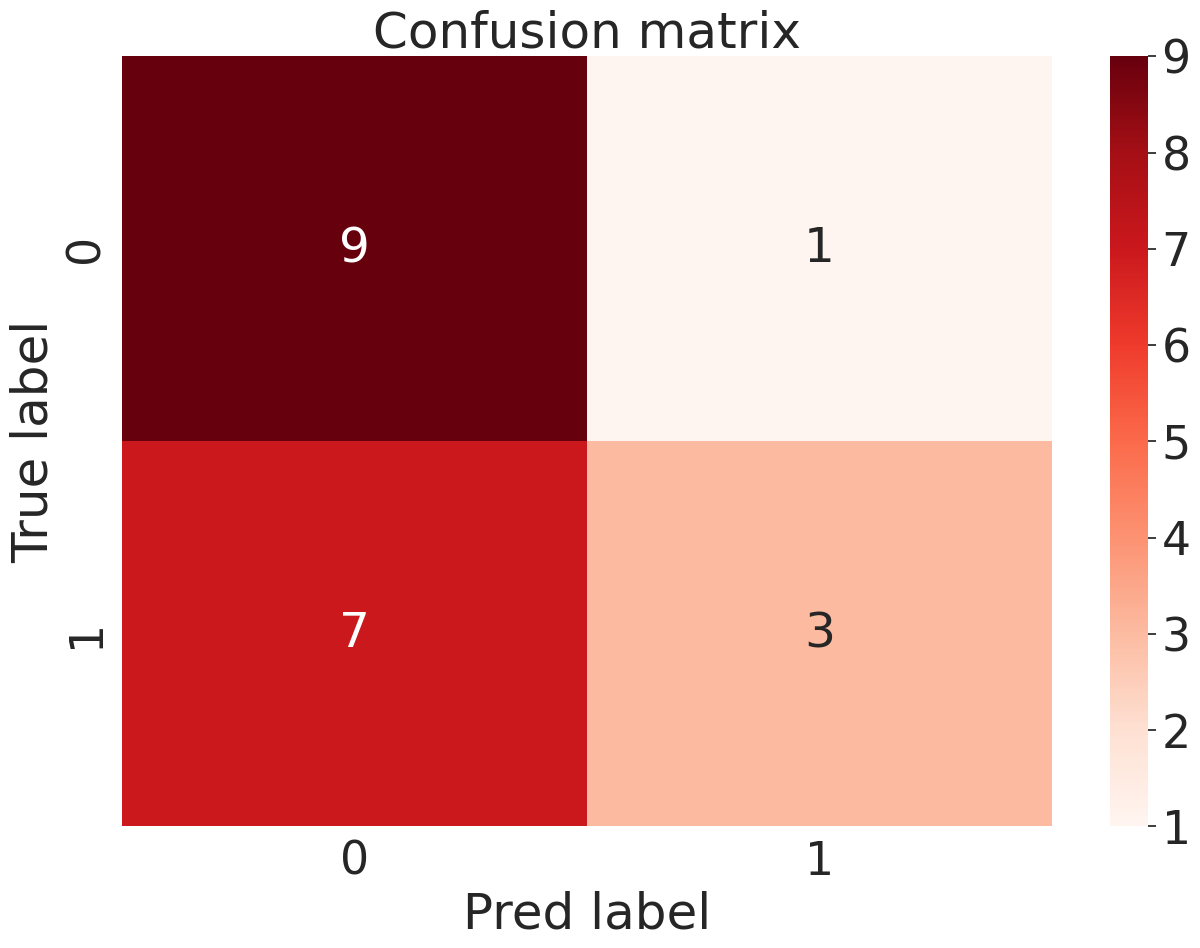

In [10]:
sns.set_theme(font_scale=3)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(15, 10))

    g = sns.heatmap(test_cm, ax=ax, annot=True, annot_kws={"fontsize": 35}, cmap="Reds")
    g.set_title("Confusion matrix")
    g.set_ylabel("True label")
    g.set_xlabel("Pred label")

In [11]:
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

print(
    f"model: {model}, outcome: {outcome}\n Acc:{test_acc:.2f}, precision: {p:.2f}, recall: {r:.2f}, f1: {f1:.2f}"
)

model: LR, outcome: DX_GROUP
 Acc:0.60, precision: 0.66, recall: 0.60, f1: 0.56


## Now let's predict scanning site!

In [12]:
outcome = "SITE_ID"
y = pheno_df[outcome]
y_counts = y.value_counts()

print(f"Unique output clasess:\n{y_counts}")

# Encode labels to integer categories
le = preprocessing.LabelEncoder()
y = le.fit_transform(y)

Unique output clasess:
PITT    50
OLIN    28
OHSU    22
Name: SITE_ID, dtype: int64


## Create train-test split
- 80/20 ratio
- Stratify 

In [13]:
from sklearn.model_selection import train_test_split

test_subset_fraction = 0.2  #
stratification = y

X_train, X_test, y_train, y_test = train_test_split(
    X,  # input features
    y,  # output labels
    test_size=test_subset_fraction,
    shuffle=True,  # shuffle dataset
    # before splitting
    stratify=stratification,
    random_state=123,  # same shuffle each time
)

# print the size of our training and test groups
print("training:", len(X_train), "testing:", len(X_test))

training: 80 testing: 20


## Fit the model

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model = "LR"  # 'LR' or 'RF'

if model == "RF":
    clf = RandomForestClassifier(max_depth=3, class_weight="balanced", random_state=0)
elif model == "LR":
    clf = LogisticRegression(
        penalty="l2", C=1, class_weight="balanced", solver="saga", random_state=0
    )
else:
    print(f"Unknown model: {model}")

print(f"Using model: {model}")

clf.fit(X_train, y_train)

train_acc = clf.score(X_train, y_train)
print(f"train acc: {train_acc:.3f}")

Using model: LR
train acc: 1.000


/home/nikhil/anaconda3/envs/qlsc612/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Evaluate on test set
- accuracy
- confusion_matrix
- precision_recall_fscore 

In [15]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(X_test)

test_acc = clf.score(X_test, y_test)
print(f"test acc: {test_acc:.3f}")

test_cm = confusion_matrix(y_test, y_pred)

test acc: 0.800


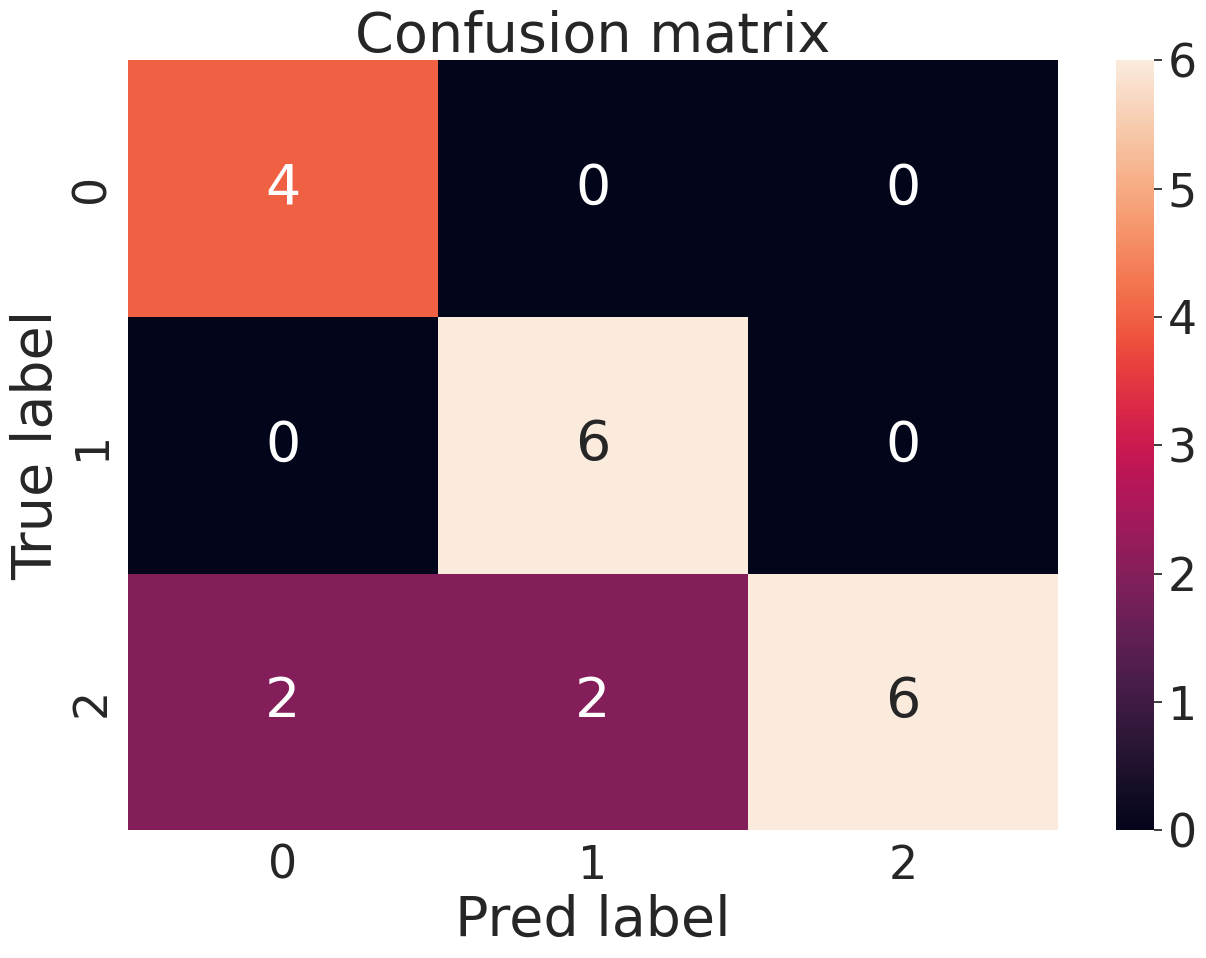

In [16]:
sns.set_theme(font_scale=3)
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(15, 10))
    g = sns.heatmap(test_cm, annot=True, ax=ax, annot_kws={"fontsize": 40})
    g.set_title("Confusion matrix", fontsize=40)
    g.set_ylabel("True label", fontsize=40)
    g.set_xlabel("Pred label", fontsize=40)

In [17]:
p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")

print(
    f"model: {model}, outcome: {outcome}\n Acc:{test_acc:.2f}, precision: {p:.2f}, recall: {r:.2f}, f1: {f1:.2f}"
)

model: LR, outcome: SITE_ID
 Acc:0.80, precision: 0.86, recall: 0.80, f1: 0.79
